In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset

from sklearn.model_selection import train_test_split

from torchsummary import summary
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path

import time

import random

import copy

import sklearn.metrics as skm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.calibration import calibration_curve
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def data_generator(path, target_size=(256, 256), augmentation=False, augmentation_factor=1):

    image_list = []

    base_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x[:3,:,:])
    ])

    # Veri artırma dönüşümleri
    augmentation_transforms = [
        # Orijinal görüntü için baz dönüşüm
        base_transform,

        # Yatay döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif döndürme
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Parlaklık ve kontrast ayarları
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif zoom
        transforms.Compose([
            transforms.Resize((int(target_size[0]*1.1), int(target_size[1]*1.1))),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ]),

        # Hafif bulanıklaştırma
        transforms.Compose([
            transforms.Resize(target_size),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3,:,:])
        ])
    ]

    image_files = sorted(os.listdir(path))

    for image_name in image_files:
        image_path = os.path.join(path, image_name)

        img = Image.open(image_path)

        # Orijinal görüntüyü ekle
        img_tensor = base_transform(img)
        image_list.append(img_tensor)

        # Eğer veri artırma isteniyorsa
        if augmentation:
            # Kaç tane dönüşüm uygulayacağımızı belirle (augmentation_factor kadar)
            num_transforms = min(augmentation_factor, len(augmentation_transforms)-1)

            # Dönüşümleri rastgele seç (ilk dönüşüm orijinal görüntü olduğu için 1'den başla)
            chosen_transforms = random.sample(range(1, len(augmentation_transforms)), num_transforms)

            for transform_idx in chosen_transforms:
                transform = augmentation_transforms[transform_idx]
                augmented_tensor = transform(img)
                image_list.append(augmented_tensor)

    data = torch.stack(image_list)
    return data

In [ ]:
# No stroke images

folder_path = "/content/drive/My Drive/veriler/train_val/inmesiz"

print("Images are loading...")
NS_images = data_generator(folder_path)

print(f"Total images: {NS_images.shape[0]}")
print(f"Shapes: {NS_images[0].shape}")

Images are loading...
Total images: 4427
Shapes: torch.Size([3, 256, 256])


In [ ]:
# Stroke images

folder_path = "/content/drive/My Drive/veriler/train_val/inmeli"

print("Images are loading...")
S_images = data_generator(folder_path, augmentation=True, augmentation_factor=1)

print(f"Total stroke images: {S_images.shape[0]}")
print(f"Stroke images shape: {S_images[0].shape}")

Images are loading...
Total stroke images: 4446
Stroke images shape: torch.Size([3, 256, 256])


In [ ]:
# Test images

folder_path_NS = "/content/drive/My Drive/veriler/test/inmesiz"
folder_path_S = "/content/drive/My Drive/veriler/test/inmeli"

print("Images are loading...")
NS_test_images = data_generator(folder_path_NS)
S_test_images = data_generator(folder_path_S)

print(f"Total no stroke test images: {NS_test_images.shape[0]}")
print(f"No stroke test images shape: {NS_test_images[0].shape}")

print(f"Total stroke test images: {S_test_images.shape[0]}")
print(f"Stroke test images shape: {S_test_images[0].shape}")

Images are loading...
Total no stroke test images: 130
No stroke test images shape: torch.Size([3, 256, 256])
Total stroke test images: 167
Stroke test images shape: torch.Size([3, 256, 256])


In [ ]:
# External test images

folder_path_external_NS = "/content/drive/My Drive/veriler/test/baska_test/inmesiz"
folder_path_external_S = "/content/drive/My Drive/veriler/test/baska_test/b_stroke"

print("Images are loading...")
external_NS_images = data_generator(folder_path_external_NS)
external_NS_images = external_NS_images[:192]
external_S_images = data_generator(folder_path_external_S)

print(f"Total external test no stroke images: {external_NS_images.shape[0]}")
print(f"External test no stroke images shape: {external_NS_images[0].shape}")

print(f"Total external test stroke images: {external_S_images.shape[0]}")
print(f"External test stroke images shape: {external_S_images[0].shape}")

Images are loading...
Total external test no stroke images: 192
External test no stroke images shape: torch.Size([3, 256, 256])
Total external test stroke images: 192
External test stroke images shape: torch.Size([3, 256, 256])


In [ ]:
# Combine the images

train_val_data = torch.cat((NS_images, S_images), dim=0)
train_val_labels = torch.cat((torch.zeros(NS_images.shape[0]), torch.ones(S_images.shape[0])), dim=0)
train_val_labels = train_val_labels[:,None]

test_data = torch.cat((NS_test_images, S_test_images), dim=0)
test_labels = torch.cat((torch.zeros(NS_test_images.shape[0]), torch.ones(S_test_images.shape[0])), dim=0)
test_labels = test_labels[:,None]

external_data = torch.cat((external_NS_images, external_S_images), dim=0)
external_labels = torch.cat(
    (
        torch.zeros(external_NS_images.shape[0]),
        torch.ones(external_S_images.shape[0])
    ),
    dim=0
)
external_labels = external_labels[:,None]

print(f"Train/val data shape: {train_val_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"External test data shape: {external_data.shape}")
print("--------------------------------")
print(f"Train/val labels shape: {train_val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"External test labels shape: {external_labels.shape}")
print("--------------------------------")
print(f"What is the label? (train/val) {train_val_labels[NS_images.shape[0]-1]}") # Has to be 0
print(f"What is the label? (test) {test_labels[NS_test_images.shape[0]-1]}") # Has to be 0
print(f"What is the label? (external) {external_labels[external_NS_images.shape[0]-1]}") # Has to be 0
print(f"What is the label? (train/val) {train_val_labels[NS_images.shape[0]]}") # Has to be 1
print(f"What is the label? (test) {test_labels[NS_test_images.shape[0]]}") # Has to be 1
print(f"What is the label? (external) {external_labels[external_NS_images.shape[0]]}") # Has to be 1

Train/val data shape: torch.Size([8873, 3, 256, 256])
Test data shape: torch.Size([297, 3, 256, 256])
External test data shape: torch.Size([384, 3, 256, 256])
--------------------------------
Train/val labels shape: torch.Size([8873, 1])
Test labels shape: torch.Size([297, 1])
External test labels shape: torch.Size([384, 1])
--------------------------------
What is the label? (train/val) tensor([0.])
What is the label? (test) tensor([0.])
What is the label? (external) tensor([0.])
What is the label? (train/val) tensor([1.])
What is the label? (test) tensor([1.])
What is the label? (external) tensor([1.])


In [ ]:
# Split the data into train and dev

train_data, dev_data, train_labels, dev_labels = train_test_split(
    train_val_data,
    train_val_labels,
    test_size=0.2
)

print(f"Train data shape: {train_data.shape}")
print(f"Dev data shape: {dev_data.shape}")
print("--------------------------------")
print(f"Train labels shape: {train_labels.shape}")
print(f"Dev labels shape: {dev_labels.shape}")

Train data shape: torch.Size([7098, 3, 256, 256])
Dev data shape: torch.Size([1775, 3, 256, 256])
--------------------------------
Train labels shape: torch.Size([7098, 1])
Dev labels shape: torch.Size([1775, 1])


In [ ]:
# Create the datasets

train_dataset = TensorDataset(train_data, train_labels)
dev_dataset = TensorDataset(dev_data, dev_labels)
test_dataset = TensorDataset(test_data, test_labels)
external_dataset = TensorDataset(external_data, external_labels)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])
external_loader = DataLoader(external_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

print(f"Train loader: {train_loader.dataset[0][0].shape}")
print(f"Dev loader: {dev_loader.dataset[0][0].shape}")
print(f"Test loader: {test_loader.dataset[0][0].shape}")
print(f"External test loader: {external_loader.dataset[0][0].shape}")

Train loader: torch.Size([3, 256, 256])
Dev loader: torch.Size([3, 256, 256])
Test loader: torch.Size([3, 256, 256])
External test loader: torch.Size([3, 256, 256])


In [ ]:
def medrix_model(printtoggle=False):

    class theNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            self.print = printtoggle

            ###--------------- Feature Map Layers ---------------###

            # First Convolutional Layer
            self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(16)
            # output size: (np.floor((256 - 3 + 2*1) / 1) + 1)/2 = 128

            # Second Convolutional Layer
            self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(32)
            # output size: (np.floor((128 - 3 + 2*1) / 1) + 1)/2 = 64

            # Third Convolutional Layer
            self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
            self.bnorm3 = nn.BatchNorm2d(64)
            # output size: (np.floor((64 - 3 + 2*1) / 1) + 1)/2 = 32

            # Fourth Convolutional Layer
            self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
            self.bnorm4 = nn.BatchNorm2d(128)
            # output size: (np.floor((32 - 3 + 2*1) / 1) + 1)/2 = 16

            # Fifth Convolutional Layer
            self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
            self.bnorm5 = nn.BatchNorm2d(256)
            # output size: (np.floor((16 - 3 + 2*1) / 1) + 1)/2 = 8

            # Sixth Convolutional Layer
            self.conv6 = nn.Conv2d(256, 512, 3, padding=1)
            self.bnorm6 = nn.BatchNorm2d(512)
            # output size: (np.floor((8 - 3 + 2*1) / 1) + 1)/2 = 4

            # Seventh Convolutional Layer
            self.conv7 = nn.Conv2d(512, 1024, 3, padding=1)
            self.bnorm7 = nn.BatchNorm2d(1024)
            # output size: (np.floor((4 - 3 + 2*1) / 1) + 1)/2 = 2

            ###-------------- Linear Desicion Layers --------------###

            self.fc1 = nn.Linear(1024*2*2, 512)
            self.fc2 = nn.Linear(512, 128)
            self.fc3 = nn.Linear(128, 32)
            self.fc4 = nn.Linear(32, 1)


        def forward(self, x):

            if self.print: print(f"Input shape: {x.shape}")

            # First Convolutional Layer
            x = F.max_pool2d(self.conv1(x),2)
            x = F.relu(self.bnorm1(x))
            if self.print: print(f"After conv1: {x.shape}")

            # Second Convolutional Layer
            x = F.max_pool2d(self.conv2(x),2)
            x = F.relu(self.bnorm2(x))
            if self.print: print(f"After conv2: {x.shape}")

            # Third Convolutional Layer
            x = F.max_pool2d(self.conv3(x),2)
            x = F.relu(self.bnorm3(x))
            if self.print: print(f"After conv3: {x.shape}")

            # Fourth Convolutional Layer
            x = F.max_pool2d(self.conv4(x),2)
            x = F.relu(self.bnorm4(x))
            if self.print: print(f"After conv4: {x.shape}")

            # Fifth Convolutional Layer
            x = F.max_pool2d(self.conv5(x),2)
            x = F.relu(self.bnorm5(x))
            if self.print: print(f"After conv5: {x.shape}")

            # Sixth Convolutional Layer
            x = F.max_pool2d(self.conv6(x),2)
            x = F.relu(self.bnorm6(x))
            if self.print: print(f"After conv6: {x.shape}")

            # Seventh Convolutional Layer
            x = F.max_pool2d(self.conv7(x),2)
            x = F.relu(self.bnorm7(x))
            if self.print: print(f"After conv7: {x.shape}")

            # Flatten the output
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f"After flatten: {x.shape}")

            # Linear Decision Layers
            x = F.relu(self.fc1(x))

            x = F.relu(self.fc2(x))

            x = F.relu(self.fc3(x))

            x = self.fc4(x)

            if self.print: print(f"Output shape: {x.shape}")

            return x

    net = theNet(printtoggle)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.0003, weight_decay=0.001)

    lossfunc = nn.BCEWithLogitsLoss()



    return net, optimizer, lossfunc

In [ ]:
net, optimizer, lossfunc = medrix_model(printtoggle=True)

X, y = next(iter(train_loader))

yHat = net(X)

loss = lossfunc(yHat, y)

print(f"Loss: {loss.item()}")

Input shape: torch.Size([32, 3, 256, 256])
After conv1: torch.Size([32, 16, 128, 128])
After conv2: torch.Size([32, 32, 64, 64])
After conv3: torch.Size([32, 64, 32, 32])
After conv4: torch.Size([32, 128, 16, 16])
After conv5: torch.Size([32, 256, 8, 8])
After conv6: torch.Size([32, 512, 4, 4])
After conv7: torch.Size([32, 1024, 2, 2])
After flatten: torch.Size([32, 4096])
Output shape: torch.Size([32, 1])
Loss: 0.6904741525650024


In [ ]:
summary(net, (3, 256, 256), device="cpu")

Input shape: torch.Size([2, 3, 256, 256])
After conv1: torch.Size([2, 16, 128, 128])
After conv2: torch.Size([2, 32, 64, 64])
After conv3: torch.Size([2, 64, 32, 32])
After conv4: torch.Size([2, 128, 16, 16])
After conv5: torch.Size([2, 256, 8, 8])
After conv6: torch.Size([2, 512, 4, 4])
After conv7: torch.Size([2, 1024, 2, 2])
After flatten: torch.Size([2, 4096])
Output shape: torch.Size([2, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 128, 128]              32
            Conv2d-3         [-1, 32, 128, 128]           4,640
       BatchNorm2d-4           [-1, 32, 64, 64]              64
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 128, 32, 32]          73,856
       BatchNorm2d-8   

In [ ]:
def func2TrainMedrixNet(printtoggle=True):

    timerInFunction = time.process_time()

    numepochs = 50

    # Early stopping parametreleri
    patience = 10
    best_val_acc = 0.0
    counter = 0
    best_model = None

    net, optimizer, lossfunc = medrix_model()

    net.to(device)

    trainAcc = torch.zeros(numepochs)
    trainLoss = torch.zeros(numepochs)
    devAcc = torch.zeros(numepochs)
    devLoss = torch.zeros(numepochs)

    for epoch in range(numepochs):

        net.train()

        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            X = X.to(device)
            y = y.to(device)

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( torch.mean( ( (yHat>0) == y ).float() ).item() )

        trainLoss[epoch] = np.mean(batchLoss)
        trainAcc[epoch] = 100*np.mean(batchAcc)

        net.eval()

        batchAcc = []
        batchLoss = []

        for X, y in dev_loader:

            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                yHat = net(X)
                loss = lossfunc(yHat, y)

            batchLoss.append(loss.item())
            batchAcc.append( torch.mean( ( (yHat>0) == y ).float() ).item() )

        current_val_loss = np.mean(batchLoss)
        current_val_acc = 100*np.mean(batchAcc)

        devLoss[epoch] = current_val_loss
        devAcc[epoch] = current_val_acc

        comptime = time.process_time() - timerInFunction

        if printtoggle:
            print(f'Epoch {epoch+1}/{numepochs} | Computing time: {comptime:.0f} sec | Train Accuracy: {trainAcc[epoch]:.2f}% | Validation Accuracy: {devAcc[epoch]:.2f}%')

        # Early stopping control
        if current_val_acc > best_val_acc:
            best_val_acc = current_val_acc
            counter = 0
            # Save the best model
            best_model = copy.deepcopy(net.state_dict())

            if printtoggle:
                print(f"The validation accuracy saved! The best validation accuracy is: {best_val_acc:.2f}%")
                print("")
        else:
            counter += 1
            if printtoggle:
                print(f"Early stopping counter: {counter}/{patience}")
                print("")

            if counter >= patience:
                if printtoggle:
                    print(f"Early stopping! With epoch {epoch+1} training stopped.")
                # Load the best model
                net.load_state_dict(best_model)
                break

    # If early stopping is not triggered, load the best model
    if best_model is not None and epoch == numepochs - 1:
        net.load_state_dict(best_model)
        if printtoggle:
            print("Training finished, the best model is loaded.")

    return trainAcc[:epoch+1], trainLoss[:epoch+1], devAcc[:epoch+1], devLoss[:epoch+1], net

In [ ]:
trainAcc, trainLoss, devAcc, devLoss, net = func2TrainMedrixNet()

Epoch 1/50 | Computing time: 26 sec | Train Accuracy: 79.62% | Validation Accuracy: 88.69%
The validation accuracy saved! The best validation accuracy is: 88.69%

Epoch 2/50 | Computing time: 51 sec | Train Accuracy: 90.51% | Validation Accuracy: 93.75%
The validation accuracy saved! The best validation accuracy is: 93.75%

Epoch 3/50 | Computing time: 76 sec | Train Accuracy: 93.85% | Validation Accuracy: 83.58%
Early stopping counter: 1/10

Epoch 4/50 | Computing time: 102 sec | Train Accuracy: 95.46% | Validation Accuracy: 94.66%
The validation accuracy saved! The best validation accuracy is: 94.66%

Epoch 5/50 | Computing time: 127 sec | Train Accuracy: 96.88% | Validation Accuracy: 91.14%
Early stopping counter: 1/10

Epoch 6/50 | Computing time: 152 sec | Train Accuracy: 97.37% | Validation Accuracy: 94.32%
Early stopping counter: 2/10

Epoch 7/50 | Computing time: 178 sec | Train Accuracy: 97.85% | Validation Accuracy: 91.70%
Early stopping counter: 3/10

Epoch 8/50 | Computing 

In [ ]:
# # Save the model
# torch.save(net.state_dict(), "medrixnet.pth")

In [ ]:
# # Load the model

# the_path = "drive/My Drive/model_weights/medrixnet.pth"

# net, _, _ = medrix_model()
# net.load_state_dict(torch.load(the_path))
# net.to(device)

<ipython-input-21-264dc8705501>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(the_path))


theNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
# Test the model

net.eval()

X,y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

with torch.no_grad():
    yHat = net(X)
    loss = lossfunc(yHat, y)

testLoss = loss.item()
testAcc = 100*torch.mean( ( (yHat>0) == y ).float() ).item()

print(f"Test Loss: {testLoss:.4f}")
print(f"Test Accuracy: {testAcc:.3f}%")

Test Loss: 0.3660
Test Accuracy: 89.899%


In [ ]:
# External results

net.eval()

batchAcc = []
batchLoss = []

for X, y in external_loader:

    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
        yHat = net(X)
        loss = lossfunc(yHat, y)

    batchLoss.append(loss.item())
    batchAcc.append( torch.mean( ( (yHat>0) == y ).float() ).item() )

externalLoss = np.mean(batchLoss)
externalAcc = 100*np.mean(batchAcc)

print(f"External Loss: {externalLoss:.4f}")
print(f"External Accuracy: {externalAcc:.3f}%")

External Loss: 0.5044
External Accuracy: 85.938%


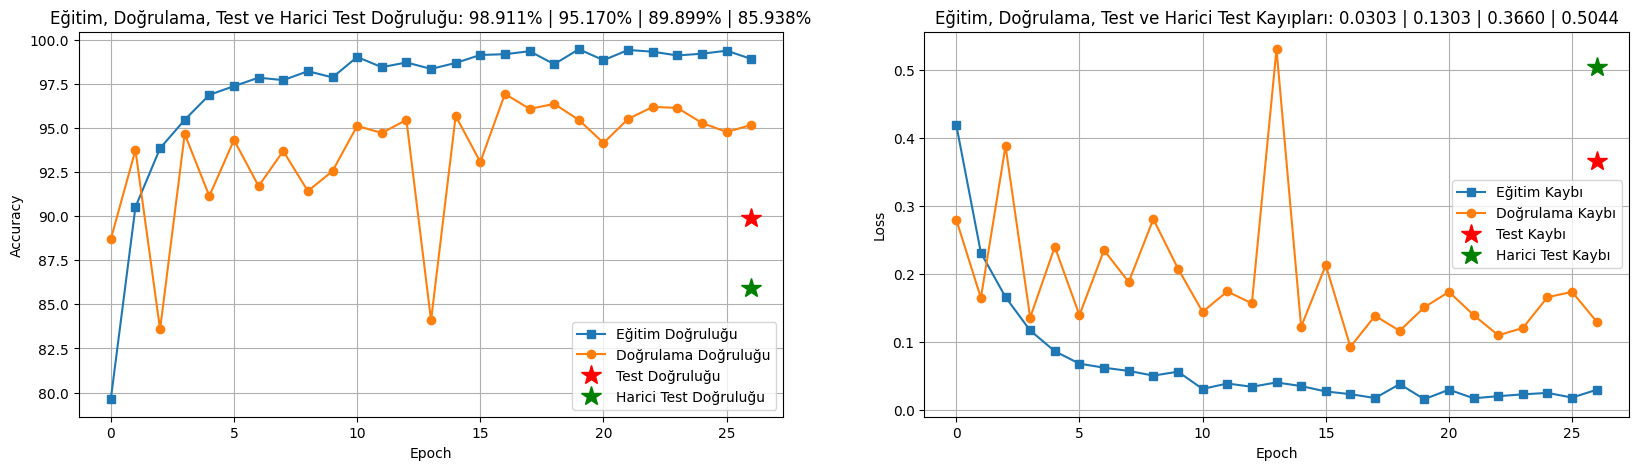

In [ ]:
# Plot the accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(trainAcc,"s-", label='Eğitim Doğruluğu')
ax[0].plot(devAcc,"o-", label='Doğrulama Doğruluğu')
ax[0].plot(trainAcc.shape[0]-1,testAcc,"r*",markersize=15, label='Test Doğruluğu')
ax[0].plot(trainAcc.shape[0]-1,externalAcc,"g*",markersize=15, label='Harici Test Doğruluğu')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title(f'Eğitim, Doğrulama, Test ve Harici Test Doğruluğu: {trainAcc[-1]:.3f}% | {devAcc[-1]:.3f}% | {testAcc:.3f}% | {externalAcc:.3f}%')
ax[0].grid()
ax[0].legend()

ax[1].plot(trainLoss,"s-", label='Eğitim Kaybı')
ax[1].plot(devLoss,"o-", label='Doğrulama Kaybı')
ax[1].plot(trainLoss.shape[0]-1,testLoss,"r*",markersize=15, label='Test Kaybı')
ax[1].plot(trainLoss.shape[0]-1,externalLoss,"g*",markersize=15, label='Harici Test Kaybı')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title(f'Eğitim, Doğrulama, Test ve Harici Test Kayıpları: {trainLoss[-1]:.4f} | {devLoss[-1]:.4f} | {testLoss:.4f} | {externalLoss:.4f}')
ax[1].grid()
ax[1].legend()

plt.show()

In [ ]:
# Predict the model

train_predictions = []
train_actual_labels = []

for X, y in train_loader:
    X = X.to(device)
    with torch.no_grad():
        yHat = net(X)
        train_predictions.append(yHat)
        train_actual_labels.append(y)

train_predictions = torch.cat(train_predictions).cpu()
train_actual_labels = torch.cat(train_actual_labels).cpu()

dev_predictions = []
dev_actual_labels = []

for X, y in dev_loader:
    X = X.to(device)
    with torch.no_grad():
        yHat = net(X)
        dev_predictions.append(yHat)
        dev_actual_labels.append(y)

dev_predictions = torch.cat(dev_predictions).cpu()
dev_actual_labels = torch.cat(dev_actual_labels).cpu()

test_predictions = []
test_actual_labels = []

for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        yHat = net(X)
        test_predictions.append(yHat)
        test_actual_labels.append(y)

test_predictions = torch.cat(test_predictions).cpu()
test_actual_labels = torch.cat(test_actual_labels).cpu()

external_predictions = []
external_actual_labels = []

for X, y in external_loader:
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        yHat = net(X)
        external_predictions.append(yHat)
        external_actual_labels.append(y)

external_predictions = torch.cat(external_predictions).cpu()
external_actual_labels = torch.cat(external_actual_labels).cpu()

print(f"Train predictions shape: {train_predictions.shape}")
print(f"Train actual labels shape: {train_actual_labels.shape}")
print(f"Dev predictions shape: {dev_predictions.shape}")
print(f"Dev actual labels shape: {dev_actual_labels.shape}")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Test actual labels shape: {test_actual_labels.shape}")
print(f"External predictions shape: {external_predictions.shape}")
print(f"External actual labels shape: {external_actual_labels.shape}")

Train predictions shape: torch.Size([7072, 1])
Train actual labels shape: torch.Size([7072, 1])
Dev predictions shape: torch.Size([1760, 1])
Dev actual labels shape: torch.Size([1760, 1])
Test predictions shape: torch.Size([297, 1])
Test actual labels shape: torch.Size([297, 1])
External predictions shape: torch.Size([384, 1])
External actual labels shape: torch.Size([384, 1])


In [ ]:
# Confusion matrices

trainConf = skm.confusion_matrix(train_actual_labels, train_predictions>0)
devConf = skm.confusion_matrix(dev_actual_labels, dev_predictions>0)
testConf = skm.confusion_matrix(test_actual_labels, test_predictions>0)
externalConf = skm.confusion_matrix(external_actual_labels, external_predictions>0)

print(f"Train confusion matrix: \n {trainConf}")
print(f"Dev confusion matrix: \n {devConf}")
print(f"Test confusion matrix: \n {testConf}")
print(f"External confusion matrix: \n {externalConf}")

Train confusion matrix: 
 [[3524    3]
 [  14 3531]]
Dev confusion matrix: 
 [[871  15]
 [ 38 836]]
Test confusion matrix: 
 [[125   5]
 [ 25 142]]
External confusion matrix: 
 [[173  19]
 [ 35 157]]


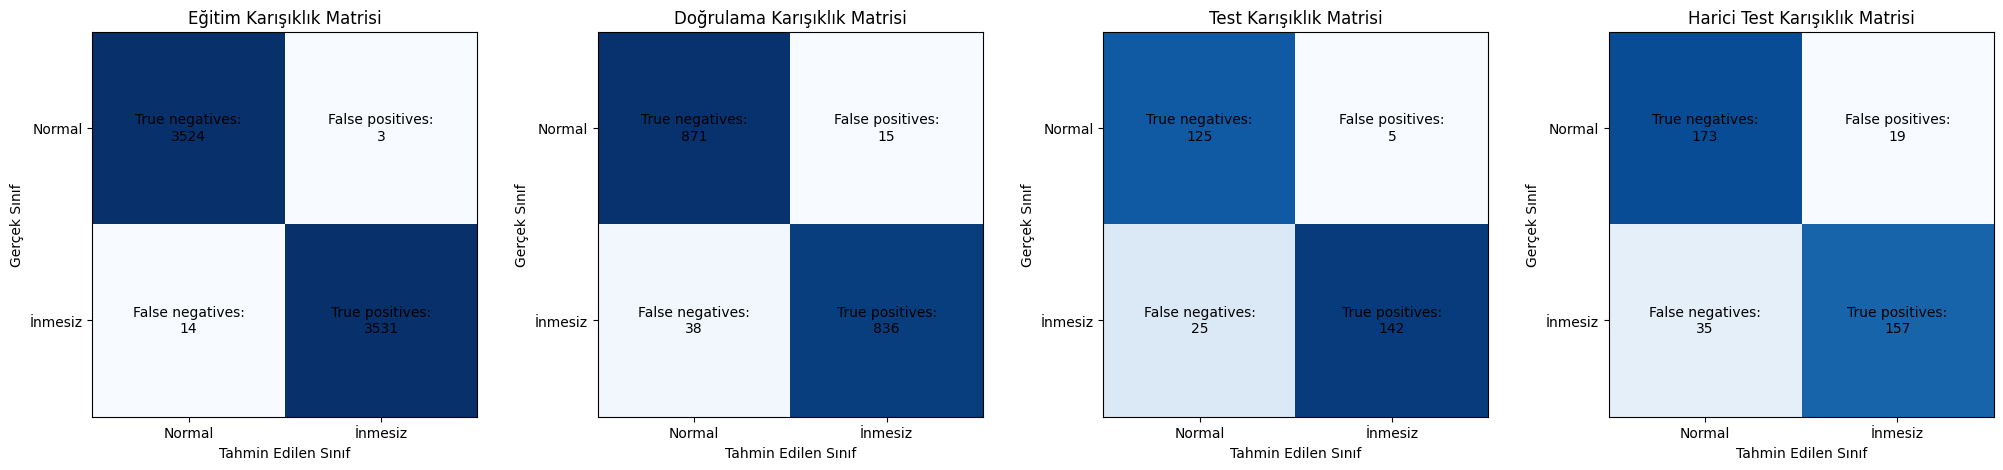

In [ ]:
# Confusion Matrices

fig,ax = plt.subplots(1,4,figsize=(25,5))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=len(train_predictions)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['Normal','İnmesiz'])
ax[0].set_yticklabels(['Normal','İnmesiz'])
ax[0].set_xlabel('Tahmin Edilen Sınıf')
ax[0].set_ylabel('Gerçek Sınıf')
ax[0].set_title('Eğitim Karışıklık Matrisi')

# add text labels
ax[0].text(0,0,f'True negatives:\n{trainConf[0,0]}' ,ha='center',va='center')
ax[0].text(0,1,f'False negatives:\n{trainConf[1,0]}',ha='center',va='center')
ax[0].text(1,1,f'True positives:\n{trainConf[1,1]}' ,ha='center',va='center')
ax[0].text(1,0,f'False positives:\n{trainConf[0,1]}',ha='center',va='center')

# confmat during DEV
ax[1].imshow(devConf,'Blues',vmax=len(dev_predictions)/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['Normal','İnmesiz'])
ax[1].set_yticklabels(['Normal','İnmesiz'])
ax[1].set_xlabel('Tahmin Edilen Sınıf')
ax[1].set_ylabel('Gerçek Sınıf')
ax[1].set_title('Doğrulama Karışıklık Matrisi')

# add text labels
ax[1].text(0,0,f'True negatives:\n{devConf[0,0]}' ,ha='center',va='center')
ax[1].text(0,1,f'False negatives:\n{devConf[1,0]}',ha='center',va='center')
ax[1].text(1,1,f'True positives:\n{devConf[1,1]}' ,ha='center',va='center')
ax[1].text(1,0,f'False positives:\n{devConf[0,1]}',ha='center',va='center')

# confmat during TEST
ax[2].imshow(testConf,'Blues',vmax=len(test_predictions)/2)
ax[2].set_xticks([0,1])
ax[2].set_yticks([0,1])
ax[2].set_xticklabels(['Normal','İnmesiz'])
ax[2].set_yticklabels(['Normal','İnmesiz'])
ax[2].set_xlabel('Tahmin Edilen Sınıf')
ax[2].set_ylabel('Gerçek Sınıf')
ax[2].set_title('Test Karışıklık Matrisi')

# add text labels
ax[2].text(0,0,f'True negatives:\n{testConf[0,0]}' ,ha='center',va='center')
ax[2].text(0,1,f'False negatives:\n{testConf[1,0]}',ha='center',va='center')
ax[2].text(1,1,f'True positives:\n{testConf[1,1]}' ,ha='center',va='center')
ax[2].text(1,0,f'False positives:\n{testConf[0,1]}',ha='center',va='center')

# confmat during EXTERNAL
ax[3].imshow(externalConf,'Blues',vmax=len(external_predictions)/2)
ax[3].set_xticks([0,1])
ax[3].set_yticks([0,1])
ax[3].set_xticklabels(['Normal','İnmesiz'])
ax[3].set_yticklabels(['Normal','İnmesiz'])
ax[3].set_xlabel('Tahmin Edilen Sınıf')
ax[3].set_ylabel('Gerçek Sınıf')
ax[3].set_title('Harici Test Karışıklık Matrisi')

# add text labels
ax[3].text(0,0,f'True negatives:\n{externalConf[0,0]}' ,ha='center',va='center')
ax[3].text(0,1,f'False negatives:\n{externalConf[1,0]}',ha='center',va='center')
ax[3].text(1,1,f'True positives:\n{externalConf[1,1]}' ,ha='center',va='center')
ax[3].text(1,0,f'False positives:\n{externalConf[0,1]}',ha='center',va='center')

plt.show()

In [ ]:
# Test & External Metrics

test_Acc = skm.accuracy_score(test_actual_labels, test_predictions>0)
test_Prec = skm.precision_score(test_actual_labels, test_predictions>0)
test_Rec = skm.recall_score(test_actual_labels, test_predictions>0)
test_F1 = skm.f1_score(test_actual_labels, test_predictions>0)

external_Acc = skm.accuracy_score(external_actual_labels, external_predictions>0)
external_Prec = skm.precision_score(external_actual_labels, external_predictions>0)
external_Rec = skm.recall_score(external_actual_labels, external_predictions>0)
external_F1 = skm.f1_score(external_actual_labels, external_predictions>0)

print("--------------- Test Metrics ---------------")
print(f"Test Accuracy: {test_Acc:.3f}")
print(f"Test Precision: {test_Prec:.3f}")
print(f"Test Recall: {test_Rec:.3f}")
print(f"Test F1 Score: {test_F1:.3f}")

print("--------------- External Metrics ---------------")
print(f"External Accuracy: {external_Acc:.3f}")
print(f"External Precision: {external_Prec:.3f}")
print(f"External Recall: {external_Rec:.3f}")
print(f"External F1 Score: {external_F1:.3f}")

--------------- Test Metrics ---------------
Test Accuracy: 0.899
Test Precision: 0.966
Test Recall: 0.850
Test F1 Score: 0.904
--------------- External Metrics ---------------
External Accuracy: 0.859
External Precision: 0.892
External Recall: 0.818
External F1 Score: 0.853


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.calibration import calibration_curve
import seaborn as sns

class BinaryConfidenceAnalysis:
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()

    def get_predictions(self):
        """Get predictions and probabilities from test data"""
        y_true = []
        y_pred = []
        y_probs = []  # Probability of positive class (class 1)

        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)

                # Handle different model output formats
                if outputs.shape[1] == 1:  # Single output (sigmoid)
                    probs = torch.sigmoid(outputs).squeeze()
                    preds = (probs >= 0.5).long()
                else:  # Two outputs (softmax)
                    probs = torch.softmax(outputs, dim=1)[:, 1]
                    preds = (probs >= 0.5).long()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_probs.extend(probs.cpu().numpy())

        return np.array(y_true), np.array(y_pred), np.array(y_probs)

    def bootstrap_metrics(self, n_iterations=1000, ci=95):
        """Calculate metrics with confidence intervals using bootstrap"""
        y_true, y_pred, _ = self.get_predictions()

        # Arrays to store bootstrap results
        precisions = np.zeros(n_iterations)
        recalls = np.zeros(n_iterations)
        f1_scores = np.zeros(n_iterations)

        n_samples = len(y_true)

        # Bootstrap loop
        for i in range(n_iterations):
            # Sample with replacement
            indices = np.random.choice(n_samples, n_samples, replace=True)

            # Calculate metrics
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_true[indices], y_pred[indices],
                average='binary', zero_division=0
            )

            precisions[i] = precision
            recalls[i] = recall
            f1_scores[i] = f1

        # Calculate confidence intervals
        alpha = (100 - ci) / 100 / 2
        ci_lower = alpha
        ci_upper = 1 - alpha

        results = {
            'precision': {
                'mean': np.mean(precisions),
                'ci': np.quantile(precisions, [ci_lower, ci_upper])
            },
            'recall': {
                'mean': np.mean(recalls),
                'ci': np.quantile(recalls, [ci_lower, ci_upper])
            },
            'f1': {
                'mean': np.mean(f1_scores),
                'ci': np.quantile(f1_scores, [ci_lower, ci_upper])
            }
        }

        return results

    def plot_metrics_with_ci(self):
        """Plot metrics with confidence intervals"""
        results = self.bootstrap_metrics()

        # Create figure
        fig, ax = plt.subplots(figsize=(10, 6))

        # Metrics to plot
        metrics = ['precision', 'recall', 'f1']
        x_pos = np.arange(len(metrics))

        # Extract values
        means = [results[m]['mean'] for m in metrics]
        errors = [
            [results[m]['mean'] - results[m]['ci'][0] for m in metrics],
            [results[m]['ci'][1] - results[m]['mean'] for m in metrics]
        ]

        # Create bar plot with error bars
        ax.bar(x_pos, means, yerr=errors, align='center', alpha=0.7, capsize=10)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(metrics)
        ax.set_ylim(0, 1.1)
        ax.set_ylabel('Score')
        ax.set_title('Performance Metrics with 95% Confidence Intervals')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Add value labels
        for i, v in enumerate(means):
            ax.text(i, v + 0.05, f'{v:.2f}', ha='center')

        return fig

    def plot_confusion_matrix(self):
        """Plot confusion matrix"""
        y_true, y_pred, _ = self.get_predictions()

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Normalize the confusion matrix
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Create plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_norm, annot=cm, fmt='g', cmap='Blues',
                    xticklabels=['Class 0', 'Class 1'],
                    yticklabels=['Class 0', 'Class 1'])
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')

        return plt.gcf()

    def plot_probability_distribution(self):
        """Plot probability distribution by class"""
        y_true, _, y_probs = self.get_predictions()

        # Ensure arrays are 1D
        y_true = np.array(y_true).flatten()
        y_probs = np.array(y_probs).flatten()

        # Debug information
        print(f"Shape of y_true: {y_true.shape}")
        print(f"Shape of y_probs: {y_probs.shape}")
        print(f"Unique values in y_true: {np.unique(y_true)}")

        plt.figure(figsize=(10, 6))

        # Create mask arrays for indexing
        mask_class0 = (y_true == 0)
        mask_class1 = (y_true == 1)

        # Make sure we have samples from both classes
        if np.any(mask_class0) and np.any(mask_class1):
            # Separate probabilities by true class
            class0_probs = y_probs[mask_class0]
            class1_probs = y_probs[mask_class1]

            # Plot distributions
            sns.histplot(class0_probs, color='blue', alpha=0.5,
                         bins=20, label='True Class 0')
            sns.histplot(class1_probs, color='red', alpha=0.5,
                         bins=20, label='True Class 1')

            # Add decision threshold line
            plt.axvline(x=0.5, color='black', linestyle='--')

            plt.xlabel('Predicted Probability of Class 1')
            plt.ylabel('Count')
            plt.title('Distribution of Predicted Probabilities by True Class')
            plt.legend()
        else:
            # Handle case where only one class is present
            present_class = 1 if np.any(mask_class1) else 0
            plt.text(0.5, 0.5, f"Only class {present_class} present in dataset",
                     ha='center', va='center', fontsize=14)
            plt.title("Unable to Plot Distribution - Single Class")

        return plt.gcf()

    def plot_calibration_curve(self):
        """Plot calibration curve with confidence interval"""
        y_true, _, y_probs = self.get_predictions()

        # Calculate calibration curve
        prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)

        # Calculate standard error for binomial proportion
        n_bins = len(prob_true)
        bin_total = np.bincount(np.digitize(y_probs, np.linspace(0, 1, n_bins + 1)) - 1,
                              minlength=n_bins)

        # For confidence interval
        std_err = np.sqrt(prob_true * (1 - prob_true) / np.maximum(bin_total, 1))
        ci = 1.96 * std_err  # 95% confidence interval

        # Plot
        plt.figure(figsize=(8, 8))
        plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

        # Plot with confidence intervals
        plt.errorbar(prob_pred, prob_true, yerr=ci,
                    marker='o', markersize=6, linewidth=2,
                    label='Model Calibration')

        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title('Calibration Curve with 95% Confidence Interval')
        plt.legend(loc='lower right')
        plt.grid(True)

        return plt.gcf()

Shape of y_true: (297,)
Shape of y_probs: (297,)
Unique values in y_true: [0. 1.]


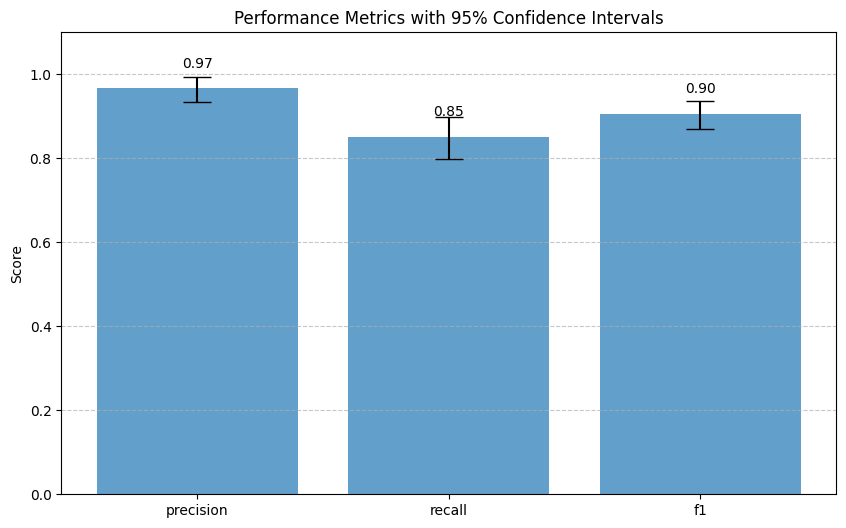

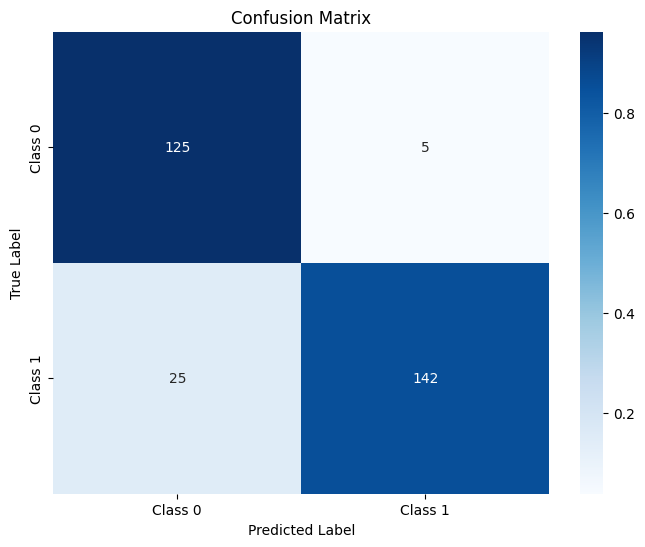

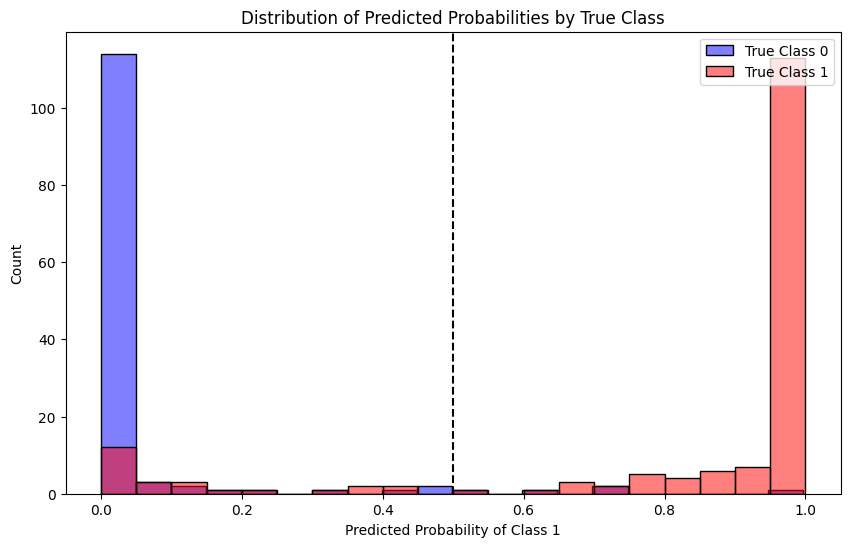

In [ ]:
analyzer = BinaryConfidenceAnalysis(net, test_loader)
#
# # Visualize metrics with confidence intervals
fig1 = analyzer.plot_metrics_with_ci()
#
# # Plot confusion matrix
fig2 = analyzer.plot_confusion_matrix()
#
# # Plot probability distributions
fig3 = analyzer.plot_probability_distribution()
# # Display all plots
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import (
    roc_curve, precision_recall_curve, roc_auc_score,
    average_precision_score, confusion_matrix, precision_score,
    recall_score, f1_score, accuracy_score, classification_report,
    log_loss, brier_score_loss
)
from sklearn.calibration import calibration_curve
import seaborn as sns
from scipy import stats
import pandas as pd
from tqdm import tqdm
from typing import Dict, Tuple, List, Optional, Union, Any

class BinaryClassificationEvaluator:
    """
    A comprehensive evaluator for binary classification models in PyTorch.
    Calculates and visualizes performance metrics with 95% confidence intervals.
    """

    def __init__(
        self,
        model: nn.Module,
        test_loader: DataLoader,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
        positive_class: int = 1,
        bootstrap_iterations: int = 1000,
        confidence_level: float = 0.95,
        save_path: Optional[str] = None
    ):
        """
        Initialize the evaluator with a model and test data loader.

        Args:
            model: Trained PyTorch model
            test_loader: PyTorch DataLoader containing test data
            device: Device to run inference on ('cuda' or 'cpu')
            positive_class: Integer representing the positive class (default: 1)
            bootstrap_iterations: Number of bootstrap iterations for CI calculation
            confidence_level: Confidence level for intervals (default: 0.95)
            save_path: Directory to save plots (default: None, doesn't save)
        """
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.positive_class = positive_class
        self.bootstrap_iterations = bootstrap_iterations
        self.confidence_level = confidence_level
        self.save_path = save_path

        # Put model in evaluation mode
        self.model.to(self.device)
        self.model.eval()

        # Run inference on test set
        self.y_true, self.y_proba = self._get_predictions()
        self.y_pred = (self.y_proba >= 0.5).astype(int)

        # Performance metrics
        self.metrics = {}
        self.bootstrap_results = {}

    def _get_predictions(self) -> Tuple[np.ndarray, np.ndarray]:
        """Get predictions from the model for the test dataset."""
        y_true_list = []
        y_proba_list = []

        with torch.no_grad():
            for inputs, targets in tqdm(self.test_loader, desc="Getting predictions"):
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                # For binary classification, model should output a single value
                # that we can pass through sigmoid for probability
                outputs = self.model(inputs)

                # Handle both single output and two-output cases
                if outputs.shape[1] == 2:  # Model outputs logits for both classes
                    proba = torch.softmax(outputs, dim=1)[:, self.positive_class]
                else:  # Model outputs a single logit
                    proba = torch.sigmoid(outputs).squeeze()

                y_true_list.append(targets.cpu().numpy())
                y_proba_list.append(proba.cpu().numpy())

        y_true = np.concatenate(y_true_list)
        y_proba = np.concatenate(y_proba_list)

        # Convert multi-class targets to binary if needed
        if len(y_true.shape) > 1:
            y_true = y_true[:, self.positive_class]

        return y_true, y_proba

    def calculate_metrics(self) -> Dict[str, float]:
        """Calculate primary classification metrics."""
        metrics = {}

        # Basic classification metrics
        metrics['accuracy'] = accuracy_score(self.y_true, self.y_pred)
        metrics['precision'] = precision_score(self.y_true, self.y_pred)
        metrics['recall'] = recall_score(self.y_true, self.y_pred)
        metrics['specificity'] = recall_score(self.y_true, self.y_pred, pos_label=0)
        metrics['f1'] = f1_score(self.y_true, self.y_pred)

        # G-mean (geometric mean of sensitivity and specificity)
        metrics['g_mean'] = np.sqrt(metrics['recall'] * metrics['specificity'])

        # AUC and Average Precision
        metrics['auc_roc'] = roc_auc_score(self.y_true, self.y_proba)
        metrics['auc_pr'] = average_precision_score(self.y_true, self.y_proba)

        # Calibration metrics
        metrics['brier_score'] = brier_score_loss(self.y_true, self.y_proba)
        metrics['log_loss'] = log_loss(self.y_true, self.y_proba)

        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(self.y_true, self.y_pred).ravel()
        metrics['true_negatives'] = tn
        metrics['false_positives'] = fp
        metrics['false_negatives'] = fn
        metrics['true_positives'] = tp

        # Positive/Negative Predictive Values
        metrics['ppv'] = tp / (tp + fp) if (tp + fp) > 0 else 0  # Same as precision
        metrics['npv'] = tn / (tn + fn) if (tn + fn) > 0 else 0

        # Likelihood ratios
        metrics['positive_likelihood'] = metrics['recall'] / (1 - metrics['specificity']) if (1 - metrics['specificity']) > 0 else float('inf')
        metrics['negative_likelihood'] = (1 - metrics['recall']) / metrics['specificity'] if metrics['specificity'] > 0 else float('inf')

        # Number needed metrics
        metrics['nnt'] = 1 / ((tp / (tp + fn)) - (fp / (fp + tn))) if ((tp / (tp + fn)) - (fp / (fp + tn))) > 0 else float('inf')

        self.metrics = metrics
        return metrics

    def bootstrap_confidence_intervals(self) -> Dict[str, Dict[str, float]]:
        """
        Calculate 95% confidence intervals for all metrics using bootstrap resampling.
        """
        bootstrap_metrics = {metric: [] for metric in self.metrics.keys()}

        # Generate random indices for bootstrap resampling
        n_samples = len(self.y_true)
        alpha = 1 - self.confidence_level

        for _ in tqdm(range(self.bootstrap_iterations), desc="Bootstrapping"):
            # Resample with replacement
            indices = np.random.choice(n_samples, n_samples, replace=True)
            y_true_bootstrap = self.y_true[indices]
            y_proba_bootstrap = self.y_proba[indices]
            y_pred_bootstrap = (y_proba_bootstrap >= 0.5).astype(int)

            # Calculate metrics for this bootstrap sample
            try:
                # Basic classification metrics
                bootstrap_metrics['accuracy'].append(accuracy_score(y_true_bootstrap, y_pred_bootstrap))
                bootstrap_metrics['precision'].append(precision_score(y_true_bootstrap, y_pred_bootstrap))
                bootstrap_metrics['recall'].append(recall_score(y_true_bootstrap, y_pred_bootstrap))
                bootstrap_metrics['specificity'].append(recall_score(y_true_bootstrap, y_pred_bootstrap, pos_label=0))
                bootstrap_metrics['f1'].append(f1_score(y_true_bootstrap, y_pred_bootstrap))

                # G-mean
                bootstrap_metrics['g_mean'].append(np.sqrt(
                    recall_score(y_true_bootstrap, y_pred_bootstrap) *
                    recall_score(y_true_bootstrap, y_pred_bootstrap, pos_label=0)
                ))

                # AUC metrics
                bootstrap_metrics['auc_roc'].append(roc_auc_score(y_true_bootstrap, y_proba_bootstrap))
                bootstrap_metrics['auc_pr'].append(average_precision_score(y_true_bootstrap, y_proba_bootstrap))

                # Calibration metrics
                bootstrap_metrics['brier_score'].append(brier_score_loss(y_true_bootstrap, y_proba_bootstrap))
                bootstrap_metrics['log_loss'].append(log_loss(y_true_bootstrap, y_proba_bootstrap))

                # Confusion matrix
                tn, fp, fn, tp = confusion_matrix(y_true_bootstrap, y_pred_bootstrap).ravel()
                bootstrap_metrics['true_negatives'].append(tn)
                bootstrap_metrics['false_positives'].append(fp)
                bootstrap_metrics['false_negatives'].append(fn)
                bootstrap_metrics['true_positives'].append(tp)

                # PPV/NPV
                bootstrap_metrics['ppv'].append(tp / (tp + fp) if (tp + fp) > 0 else 0)
                bootstrap_metrics['npv'].append(tn / (tn + fn) if (tn + fn) > 0 else 0)

                # Likelihood ratios
                spec = recall_score(y_true_bootstrap, y_pred_bootstrap, pos_label=0)
                sens = recall_score(y_true_bootstrap, y_pred_bootstrap)
                bootstrap_metrics['positive_likelihood'].append(sens / (1 - spec) if (1 - spec) > 0 else float('inf'))
                bootstrap_metrics['negative_likelihood'].append((1 - sens) / spec if spec > 0 else float('inf'))

                # NNT
                prevalence = np.mean(y_true_bootstrap)
                sens_spec_diff = sens - (1 - spec)
                bootstrap_metrics['nnt'].append(1 / sens_spec_diff if sens_spec_diff > 0 else float('inf'))

            except Exception as e:
                # Skip this bootstrap sample if it causes an error (e.g., division by zero)
                continue

        # Calculate confidence intervals
        ci_results = {}
        for metric, values in bootstrap_metrics.items():
            values = np.array(values)
            # Filter out infinite values for percentile calculation
            finite_values = values[np.isfinite(values)]
            if len(finite_values) > 0:
                lower = np.percentile(finite_values, alpha/2 * 100)
                upper = np.percentile(finite_values, (1 - alpha/2) * 100)
                ci_results[metric] = {
                    'value': self.metrics[metric],
                    'lower': lower,
                    'upper': upper
                }
            else:
                ci_results[metric] = {
                    'value': self.metrics[metric],
                    'lower': None,
                    'upper': None
                }

        self.bootstrap_results = ci_results
        return ci_results

    def plot_confusion_matrix(self, title: str = "Confusion Matrix") -> plt.Figure:
        """Plot confusion matrix with annotations."""
        cm = confusion_matrix(self.y_true, self.y_pred)

        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

        # Add labels, title and ticks
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title(title)
        ax.xaxis.set_ticklabels(['Negative', 'Positive'])
        ax.yaxis.set_ticklabels(['Negative', 'Positive'])

        plt.tight_layout()

        if self.save_path:
            plt.savefig(f"{self.save_path}/confusion_matrix.png", dpi=300, bbox_inches='tight')

        return fig

    def plot_roc_curve(self, title: str = "ROC Curve") -> plt.Figure:
        """Plot ROC curve with 95% confidence interval using bootstrapping."""
        fpr, tpr, _ = roc_curve(self.y_true, self.y_proba)
        auc = self.metrics['auc_roc']
        ci_lower = self.bootstrap_results['auc_roc']['lower']
        ci_upper = self.bootstrap_results['auc_roc']['upper']

        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot the main ROC curve
        ax.plot(fpr, tpr, 'b-', label=f'AUC = {auc:.3f} (95% CI: {ci_lower:.3f}-{ci_upper:.3f})')

        # Generate bootstrapped ROC curves for CI visualization (optional, can be resource-intensive)
        n_samples = min(50, self.bootstrap_iterations)  # Use a subset for visualization
        sample_indices = np.random.choice(self.bootstrap_iterations, n_samples, replace=False)

        for _ in range(n_samples):
            indices = np.random.choice(len(self.y_true), len(self.y_true), replace=True)
            y_true_bootstrap = self.y_true[indices]
            y_proba_bootstrap = self.y_proba[indices]

            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_proba_bootstrap)
            ax.plot(fpr, tpr, 'b-', alpha=0.05)

        # Plot the diagonal reference line
        ax.plot([0, 1], [0, 1], 'r--')

        # Add labels and title
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(title)
        ax.legend(loc='lower right')

        # Set limits
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])

        plt.tight_layout()

        if self.save_path:
            plt.savefig(f"{self.save_path}/roc_curve.png", dpi=300, bbox_inches='tight')

        return fig

    def plot_precision_recall_curve(self, title: str = "Precision-Recall Curve") -> plt.Figure:
        """Plot precision-recall curve with 95% confidence interval."""
        precision, recall, _ = precision_recall_curve(self.y_true, self.y_proba)
        auc_pr = self.metrics['auc_pr']
        ci_lower = self.bootstrap_results['auc_pr']['lower']
        ci_upper = self.bootstrap_results['auc_pr']['upper']

        # Calculate the baseline (prevalence of positive class)
        baseline = np.mean(self.y_true)

        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot the main PR curve
        ax.plot(recall, precision, 'b-', label=f'AUPRC = {auc_pr:.3f} (95% CI: {ci_lower:.3f}-{ci_upper:.3f})')

        # Generate bootstrapped PR curves for CI visualization
        n_samples = min(50, self.bootstrap_iterations)

        for _ in range(n_samples):
            indices = np.random.choice(len(self.y_true), len(self.y_true), replace=True)
            y_true_bootstrap = self.y_true[indices]
            y_proba_bootstrap = self.y_proba[indices]

            p, r, _ = precision_recall_curve(y_true_bootstrap, y_proba_bootstrap)
            ax.plot(r, p, 'b-', alpha=0.05)

        # Plot the baseline
        ax.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (Prevalence = {baseline:.3f})')

        # Add labels and title
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(title)
        ax.legend(loc='best')

        # Set limits
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])

        plt.tight_layout()

        if self.save_path:
            plt.savefig(f"{self.save_path}/pr_curve.png", dpi=300, bbox_inches='tight')

        return fig

    def plot_calibration_curve(self, n_bins: int = 10, title: str = "Calibration Curve") -> plt.Figure:
        """Plot calibration (reliability) curve."""
        prob_true, prob_pred = calibration_curve(self.y_true, self.y_proba, n_bins=n_bins)

        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot the calibration curve
        ax.plot(prob_pred, prob_true, 's-', label='Model')

        # Plot the perfectly calibrated line
        ax.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')

        # Add labels and title
        ax.set_xlabel('Mean predicted probability')
        ax.set_ylabel('Fraction of positives')
        ax.set_title(title)
        ax.legend(loc='best')

        # Set limits
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])

        # Add Brier score and Log-loss to the plot
        brier = self.metrics['brier_score']
        logloss = self.metrics['log_loss']
        ax.text(0.05, 0.95, f'Brier Score: {brier:.3f}\nLog Loss: {logloss:.3f}',
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        plt.tight_layout()

        if self.save_path:
            plt.savefig(f"{self.save_path}/calibration_curve.png", dpi=300, bbox_inches='tight')

        return fig

    def plot_threshold_analysis(self, n_thresholds: int = 100, title: str = "Threshold Analysis") -> plt.Figure:
        """Plot multiple metrics across different threshold values."""
        thresholds = np.linspace(0, 1, n_thresholds)

        # Initialize arrays to store metric values
        accuracies = np.zeros(n_thresholds)
        precisions = np.zeros(n_thresholds)
        recalls = np.zeros(n_thresholds)
        specificities = np.zeros(n_thresholds)
        f1_scores = np.zeros(n_thresholds)
        g_means = np.zeros(n_thresholds)

        # Calculate metrics at each threshold
        for i, threshold in enumerate(thresholds):
            y_pred_threshold = (self.y_proba >= threshold).astype(int)

            accuracies[i] = accuracy_score(self.y_true, y_pred_threshold)

            # Handle division by zero
            with np.errstate(divide='ignore', invalid='ignore'):
                precisions[i] = precision_score(self.y_true, y_pred_threshold, zero_division=0)
                recalls[i] = recall_score(self.y_true, y_pred_threshold, zero_division=0)
                specificities[i] = recall_score(self.y_true, y_pred_threshold, pos_label=0, zero_division=0)
                f1_scores[i] = f1_score(self.y_true, y_pred_threshold, zero_division=0)
                g_means[i] = np.sqrt(recalls[i] * specificities[i])

        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot each metric
        ax.plot(thresholds, accuracies, 'b-', label='Accuracy')
        ax.plot(thresholds, precisions, 'g-', label='Precision')
        ax.plot(thresholds, recalls, 'r-', label='Recall (Sensitivity)')
        ax.plot(thresholds, specificities, 'c-', label='Specificity')
        ax.plot(thresholds, f1_scores, 'm-', label='F1 Score')
        ax.plot(thresholds, g_means, 'y-', label='G-Mean')

        # Mark the default threshold (0.5)
        ax.axvline(x=0.5, color='k', linestyle='--', label='Default threshold (0.5)')

        # Add labels and title
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Metric Value')
        ax.set_title(title)
        ax.legend(loc='best')

        # Set limits
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])

        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()

        if self.save_path:
            plt.savefig(f"{self.save_path}/threshold_analysis.png", dpi=300, bbox_inches='tight')

        return fig

    def plot_decision_curve(self, n_thresholds: int = 100, title: str = "Decision Curve Analysis") -> plt.Figure:
        """
        Plot decision curve analysis showing net benefit across threshold probabilities.

        Net benefit = (true positives / n) - (false positives / n) * (pt/(1-pt))
        where pt is the threshold probability.
        """
        thresholds = np.linspace(0.01, 0.99, n_thresholds)  # Avoid 0 and 1

        # Initialize arrays for net benefit
        net_benefit_model = np.zeros(n_thresholds)
        net_benefit_all = np.zeros(n_thresholds)  # Treat all
        net_benefit_none = np.zeros(n_thresholds)  # Treat none

        n_samples = len(self.y_true)
        prevalence = np.mean(self.y_true)

        # Calculate net benefit at each threshold
        for i, threshold in enumerate(thresholds):
            y_pred_threshold = (self.y_proba >= threshold).astype(int)

            # Calculate true positives and false positives
            tp = np.sum((self.y_true == 1) & (y_pred_threshold == 1))
            fp = np.sum((self.y_true == 0) & (y_pred_threshold == 1))

            # Calculate net benefit (basic DCA formula)
            pt_factor = threshold / (1 - threshold)
            net_benefit_model[i] = (tp / n_samples) - (fp / n_samples) * pt_factor

            # Net benefit if treating all patients
            net_benefit_all[i] = prevalence - (1 - prevalence) * pt_factor

            # Net benefit if treating no patients
            net_benefit_none[i] = 0

        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot decision curves
        ax.plot(thresholds, net_benefit_model, 'b-', label='Model')
        ax.plot(thresholds, net_benefit_all, 'g-', label='Treat all')
        ax.plot(thresholds, net_benefit_none, 'r-', label='Treat none')

        # Add labels and title
        ax.set_xlabel('Threshold Probability')
        ax.set_ylabel('Net Benefit')
        ax.set_title(title)
        ax.legend(loc='best')

        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()

        if self.save_path:
            plt.savefig(f"{self.save_path}/decision_curve.png", dpi=300, bbox_inches='tight')

        return fig

    def print_metrics_table(self) -> pd.DataFrame:
        """Print a formatted table of metrics with confidence intervals."""
        if not self.bootstrap_results:
            print("Bootstrap confidence intervals have not been calculated yet.")
            return None

        # Create a DataFrame for better display
        metrics_df = pd.DataFrame(columns=['Metric', 'Value', '95% CI'])

        # Add rows for each metric
        for metric, data in self.bootstrap_results.items():
            # Format the values
            value = data['value']
            lower = data['lower']
            upper = data['upper']

            # Handle potential None values
            if lower is None or upper is None:
                ci_str = "N/A"
            else:
                ci_str = f"{lower:.3f} - {upper:.3f}"

            # Format value based on type
            if isinstance(value, float):
                value_str = f"{value:.3f}"
            else:
                value_str = str(value)

            # Add to DataFrame
            metrics_df = pd.concat([metrics_df, pd.DataFrame([{
                'Metric': metric.replace('_', ' ').title(),
                'Value': value_str,
                '95% CI': ci_str
            }])], ignore_index=True)

        # Print and return the DataFrame
        print(metrics_df.to_string(index=False))
        return metrics_df

    def save_metrics_to_csv(self, filename: str = "metrics.csv") -> None:
        """Save metrics with confidence intervals to a CSV file."""
        metrics_df = self.print_metrics_table()

        if self.save_path:
            metrics_df.to_csv(f"{self.save_path}/{filename}", index=False)
        else:
            metrics_df.to_csv(filename, index=False)

    def evaluate(self, print_results: bool = True, plot_results: bool = True) -> Dict[str, Any]:
        """
        Run the full evaluation pipeline and return all results.

        Args:
            print_results: Whether to print the metrics table
            plot_results: Whether to generate and show plots

        Returns:
            Dictionary containing all calculated metrics and confidence intervals
        """
        # Calculate metrics
        self.calculate_metrics()

        # Calculate confidence intervals
        self.bootstrap_confidence_intervals()

        # Print metrics table
        if print_results:
            self.print_metrics_table()

        # Generate plots
        if plot_results:
            self.plot_confusion_matrix()
            self.plot_roc_curve()
            self.plot_precision_recall_curve()
            self.plot_calibration_curve()
            self.plot_threshold_analysis()
            self.plot_decision_curve()
            plt.show()

        # If save_path is provided, save metrics to CSV
        if self.save_path:
            self.save_metrics_to_csv()

        # Return all results
        return {
            'metrics': self.metrics,
            'ci': self.bootstrap_results
        }


def evaluate_binary_classifier(
    model: nn.Module,
    test_loader: DataLoader,
    save_path: Optional[str] = None,
    bootstrap_iterations: int = 1000,
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
) -> Dict[str, Any]:
    """
    Convenience function to evaluate a binary classifier and generate all plots and metrics.

    Args:
        model: Trained PyTorch model
        test_loader: PyTorch DataLoader containing test data
        save_path: Directory to save results (default: None, doesn't save)
        bootstrap_iterations: Number of bootstrap iterations for CI calculation
        device: Device to run inference on ('cuda' or 'cpu')

    Returns:
        Dictionary containing all calculated metrics and confidence intervals
    """
    evaluator = BinaryClassificationEvaluator(
        model=model,
        test_loader=test_loader,
        device=device,
        bootstrap_iterations=bootstrap_iterations,
        save_path=save_path
    )

    results = evaluator.evaluate()
    return results


# Example usage:
"""
# Load your saved model
model = YourModelClass(...)
model.load_state_dict(torch.load('model_checkpoint.pth'))

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the model
results = evaluate_binary_classifier(
    model=model,
    test_loader=test_loader,
    save_path='./evaluation_results',
    bootstrap_iterations=1000  # Reduce for faster results, increase for more reliable CIs
)

# Access specific metrics
auc_roc = results['metrics']['auc_roc']
auc_roc_ci = results['ci']['auc_roc']
print(f"AUC-ROC: {auc_roc:.3f} (95% CI: {auc_roc_ci['lower']:.3f}-{auc_roc_ci['upper']:.3f})")
"""